# Clustering & Recommendation of IT Support Tickets

### Contributers: Jackson Cockrum , Charlotte Hauke
### CSCI 4022 - Advanced Data Science Spring 2025

In [48]:
#Imports
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
#Import Data

og_df = pd.read_csv("data/dataset-tickets-multi-lang-4-20k.csv")
og_df.info()
og_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   subject   18539 non-null  object
 1   body      19998 non-null  object
 2   answer    19996 non-null  object
 3   type      20000 non-null  object
 4   queue     20000 non-null  object
 5   priority  20000 non-null  object
 6   language  20000 non-null  object
 7   tag_1     20000 non-null  object
 8   tag_2     19954 non-null  object
 9   tag_3     19905 non-null  object
 10  tag_4     18461 non-null  object
 11  tag_5     13091 non-null  object
 12  tag_6     7351 non-null   object
 13  tag_7     3928 non-null   object
 14  tag_8     1907 non-null   object
dtypes: object(15)
memory usage: 2.3+ MB


,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


### Clean and Preprocess Data

In [50]:
#Remove tickets not in english
df = og_df[og_df['language']=="en"]
df = df.drop(columns='language')

In [51]:
#Combine tags into 1 string and sort alphabetically
tag_cols = ['tag_1','tag_2','tag_3','tag_4','tag_5','tag_6','tag_7','tag_8']
df[tag_cols] = df[tag_cols].fillna('').astype(str)
df['tags'] = df[tag_cols].agg(lambda row: ' '.join(sorted(row)), axis=1)
df = df.drop(columns=tag_cols)
df.head()


,subject,body,answer,type,queue,priority,tags
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,Feedback IT Sales Tech Support
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,Documentation Feature Guidance Performance P...
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,Breach Compliance Customer Documentation Gui...
5,Concerns About Securing Medical Data on 2-in-1...,Inquiring about best practices for securing me...,Thank you for your concern regarding securing ...,Request,Technical Support,medium,Feature IT Product Security Tech Support
7,Problem with Integration,"The integration stopped working unexpectedly, ...",I will look into the problem and call you at <...,Problem,IT Support,high,Bug Documentation Integration Outage Resolut...


In [52]:
#Check for weird values
for col in df:
    num_unique = df[col].nunique()
    print(col, num_unique)

print(df['type'].unique())
print(df['queue'].unique())
print(df['priority'].unique())

subject 10891
body 11922
answer 11920
type 4
queue 10
priority 3
tags 5679
['Request' 'Problem' 'Incident' 'Change']
['Customer Service' 'Technical Support' 'IT Support' 'Product Support'
 'Billing and Payments' 'Service Outages and Maintenance'
 'Human Resources' 'Returns and Exchanges' 'Sales and Pre-Sales'
 'General Inquiry']
['medium' 'high' 'low']


In [53]:
#Strip punctuation for clustering, keep unedited body and answercolumns to show in results
#TODO not sure is this would be easier to do when actually clustering
df['body_stripped'] = df['body'].str.replace(f"[{string.punctuation}]", "", regex=True).str.lower()
df['answer_stripped'] = df['answer'].str.replace(f"[{string.punctuation}]", "", regex=True).str.lower() 

df.head()

,subject,body,answer,type,queue,priority,tags,body_stripped,answer_stripped
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,Feedback IT Sales Tech Support,seeking information on digital strategies that...,we offer a variety of digital strategies and s...
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,Documentation Feature Guidance Performance P...,i am contacting you to request information on ...,i am here to assist you with data analytics to...
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,Breach Compliance Customer Documentation Gui...,dear customer support i am reaching out to inq...,dear name we take the security of medical data...
5,Concerns About Securing Medical Data on 2-in-1...,Inquiring about best practices for securing me...,Thank you for your concern regarding securing ...,Request,Technical Support,medium,Feature IT Product Security Tech Support,inquiring about best practices for securing me...,thank you for your concern regarding securing ...
7,Problem with Integration,"The integration stopped working unexpectedly, ...",I will look into the problem and call you at <...,Problem,IT Support,high,Bug Documentation Integration Outage Resolut...,the integration stopped working unexpectedly c...,i will look into the problem and call you at t...


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11923 entries, 1 to 19997
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   subject          10891 non-null  object
 1   body             11922 non-null  object
 2   answer           11920 non-null  object
 3   type             11923 non-null  object
 4   queue            11923 non-null  object
 5   priority         11923 non-null  object
 6   tags             11923 non-null  object
 7   body_stripped    11922 non-null  object
 8   answer_stripped  11920 non-null  object
dtypes: object(9)
memory usage: 931.5+ KB


### Exploratory Data Analysis

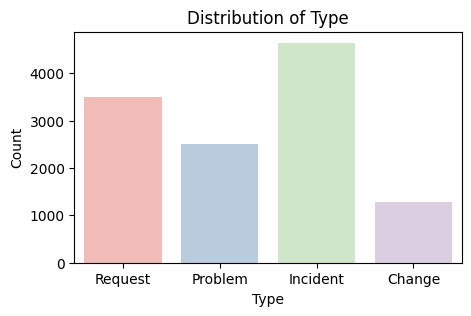

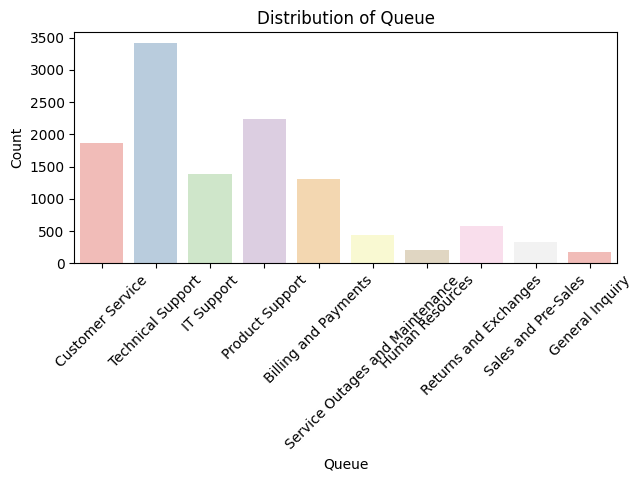

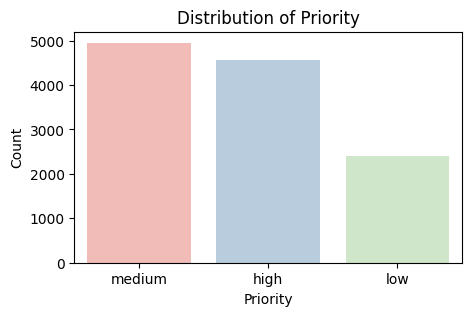

In [91]:
plt.figure(figsize=(5, 3))
sns.countplot(x='type', data=df,palette='Pastel1',hue='type')
plt.title('Distribution of Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(7, 3))
sns.countplot(x='queue', data=df, hue='queue',palette='Pastel1')
plt.title('Distribution of Queue')
plt.xlabel('Queue')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(5, 3))
sns.countplot(x='priority', data=df, palette='Pastel1',hue='priority')
plt.title('Distribution of Priority')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.show()